# ==============================================================================
# REQUIRED LIBRARIES
# ==============================================================================

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# ==============================================================================
# DATA PREPROCESSING
# ==============================================================================


In [2]:
# Define the column names for the NSL-KDD dataset
column_names = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
    "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
    "root_shell","su_attempted","num_root","num_file_creations","num_shells",
    "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count",
    "srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
    "same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count",
    "dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
    "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
    "dst_host_srv_rerror_rate","label", "difficulty"
]

# --- LOCAL FILE PATHS ---
# Load datasets directly from the local file system.
train_path = "KDDTrain+.csv"
test_path = "KDDTest+.csv"

df_train = pd.read_csv(train_path, header=None, names=column_names)
df_test = pd.read_csv(test_path, header=None, names=column_names)
# ------------------------

In [3]:
# The 'difficulty' column is not required for model training and is dropped.
df_train.drop("difficulty", axis=1, inplace=True)
df_test.drop("difficulty", axis=1, inplace=True)

print('Dimensions of the Training set:', df_train.shape)
print('Dimensions of the Test set:', df_test.shape)

# Check for missing values 
print("\nChecking for Null Values:")
print(f"Total Null values in Training set: {df_train.isna().sum().sum()}")
print(f"Total Null values in Test set: {df_test.isna().sum().sum()}")

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22543, 42)

Checking for Null Values:
Total Null values in Training set: 0
Total Null values in Test set: 0


In [4]:
def group_attack_labels(df):
    """
    Groups the 42 unique attack labels into 5 main categories (DoS, R2L, Probe, U2R, Normal).
    Fixes the Pandas SettingWithCopyWarning by explicitly assigning the modified series back.
    """
    labels = df['label'].copy()

    # Denial of Service (DoS) attacks
    labels.replace([
        'apache2','back','land','neptune','mailbomb','pod','processtable',
        'smurf','teardrop','udpstorm','worm'
    ], 'DoS', inplace=True)

    # Remote to Local (R2L) attacks
    labels.replace([
        'ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf',
        'sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster',
        'xlock','xsnoop'
    ], 'R2L', inplace=True)

    # Probing attacks
    labels.replace([
        'ipsweep','mscan','nmap','portsweep','saint','satan'
    ], 'Probe', inplace=True)

    # User to Root (U2R) attacks
    labels.replace([
        'buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'
    ], 'U2R', inplace=True)
    
    df['label'] = labels # Assign the modified series back to the DataFrame
    
group_attack_labels(df_train)
group_attack_labels(df_test)


# Separate features (X) and labels (y)
X_train = df_train.drop(['label'], axis=1)
y_train = df_train['label']
X_test = df_test.drop(['label'], axis=1)
y_test = df_test['label']


# ==============================================================================
# FEATURE ENGINEERING: ENCODING AND SCALING
# ==============================================================================

In [5]:
# Identify categorical and numerical columns for preprocessing
categorical_cols = ['protocol_type', 'service', 'flag']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Crucial Step: Fit the preprocessor ONLY on the training data, then transform both
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# FIX: Convert the sparse matrices to dense NumPy arrays immediately.
# This prevents the AttributeError later in the sampling functions.
if hasattr(X_train_processed, 'toarray'):
    X_train_processed = X_train_processed.toarray()
if hasattr(X_test_processed, 'toarray'):
    X_test_processed = X_test_processed.toarray()

In [6]:
# Label Encoding for output classes (y_train, y_test)
le = LabelEncoder()
le.fit(pd.concat([df_train['label'], df_test['label']], axis=0))

y_train_encoded = le.transform(df_train['label'])
y_test_encoded = le.transform(df_test['label'])

# Convert integer labels to one-hot categorical format for Keras/TensorFlow
num_classes = len(le.classes_)
y_train_cat = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes)


In [7]:
# Display the class-to-integer mapping for verification
print("\nClass-to-Integer Mapping:")
for i, cls in enumerate(le.classes_):
    print(f"{i} -> {cls}")

print('\nDimensions of the Processed Training set:', X_train_processed.shape)
print('Dimensions of the Processed Test set:', X_test_processed.shape)


Class-to-Integer Mapping:
0 -> DoS
1 -> Probe
2 -> R2L
3 -> U2R
4 -> normal

Dimensions of the Processed Training set: (125973, 122)
Dimensions of the Processed Test set: (22543, 122)


# ==============================================================================
# UTILITY FUNCTION: EXTRACT SINGLE PRE-PROCESSED INPUT
# ==============================================================================

In [8]:
def get_sample_vector(row_idx=None, class_name=None, class_instance=0):
    """
    Extracts and prints a single pre-processed input vector in C-style array format.
    """

    if row_idx is not None:
        idx = row_idx
    elif class_name is not None:
        encoded_class = le.transform([class_name])[0]
        indices = np.where(y_test_encoded == encoded_class)[0]
        
        if len(indices) == 0:
            raise ValueError(f"No samples found for class '{class_name}'")
        if class_instance >= len(indices):
            raise ValueError(f"Requested instance {class_instance} (0-indexed) "
                             f"but only {len(indices)} samples exist for class '{class_name}'")
        idx = indices[class_instance]
    else:
        raise ValueError("You must specify either row_idx or class_name.")

    # FIX: X_test_processed is now a dense array, so we don't need .toarray()
    row_dense = X_test_processed[idx].flatten()

    print("\n// C-Style Input Vector")
    print("{")
    print(", ".join([f"{x:.6f}f" for x in row_dense]))
    print("};")

    true_label_enc = y_test_encoded[idx]
    true_label_name = le.inverse_transform([true_label_enc])[0]
    print(f"\nRow index (in X_test_processed): {idx}")
    print(f"True label (encoded): {true_label_enc}")
    print(f"Label name: {true_label_name}")

# Example usage: Extract and print one sample for each major class
print("\n" + "="*50)
print("EXTRACTING SAMPLE INPUT VECTORS FOR C/VERILOG DEBUGGING")
get_sample_vector(class_name="normal", class_instance=0)
get_sample_vector(class_name="DoS", class_instance=0)
get_sample_vector(class_name="Probe", class_instance=0)
get_sample_vector(class_name="R2L", class_instance=99)
get_sample_vector(class_name="U2R", class_instance=0)
print("="*50)


EXTRACTING SAMPLE INPUT VECTORS FOR C/VERILOG DEBUGGING

// C-Style Input Vector
{
0.000000f, 1.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 1.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 0.000000f, 1.000000f, 0.0

In [9]:
def save_full_testset(X_test_processed, y_test_encoded,
                      input_file="inputs.txt", label_file="labels.txt"):
    """Saves the full pre-processed test set into text files for hardware simulation."""
    with open(input_file, "w") as f_in, open(label_file, "w") as f_lab:
        for i in range(X_test_processed.shape[0]):
            # FIX: X_test_processed is guaranteed dense here, so no .toarray() needed
            row_dense = X_test_processed[i].flatten()
            row_str = ", ".join([f"{x:.6f}f" for x in row_dense])
            f_in.write("{ " + row_str + " };\n")

            # Write numerical label
            f_lab.write(f"{y_test_encoded[i]}\n")

# Execute: Save the entire test set
save_full_testset(X_test_processed, y_test_encoded)
print("\nFull test set saved to inputs.txt and labels.txt.")


Full test set saved to inputs.txt and labels.txt.


# ==============================================================================
# BUILDING THE MLP MODEL WITH FOCAL LOSS
# ==============================================================================

In [10]:
# Focal Loss is often used for highly imbalanced datasets like NSL-KDD
def focal_loss(gamma=2., alpha=None):
    """Custom Focal Loss implementation for TensorFlow/Keras."""
    alpha = tf.constant(alpha, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        cross_entropy = -y_true * tf.math.log(y_pred)
        alpha_weight = tf.reduce_sum(alpha * y_true, axis=1, keepdims=True)
        focal_weight = tf.math.pow(1 - y_pred, gamma)
        loss = alpha_weight * focal_weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

    return loss_fn


In [11]:
# Define the MLP architecture
model = Sequential([
    Input(shape=(X_train_processed.shape[1],), name='input_layer'),

    # Layer 0
    Dense(256, use_bias=True, name='dense_0'),
    BatchNormalization(name='bn_0'),
    Activation('relu', name='act_0'),          # Activation happens AFTER BN
    Dropout(0.4),

    # Layer 1
    Dense(128, use_bias=True, name='dense_1'),
    BatchNormalization(name='bn_1'),
    Activation('relu', name='act_1'),
    Dropout(0.3),

    # Layer 2
    Dense(64, use_bias=True, name='dense_2'),
    BatchNormalization(name='bn_2'),
    Activation('relu', name='act_2'),
    Dropout(0.2),

    # Layer 3
    Dense(32, use_bias=True, name='dense_3'),
    BatchNormalization(name='bn_3'),
    Activation('relu', name='act_3'),
    Dropout(0.1),

    # Output Layer (No BN, just Softmax)
    Dense(num_classes, activation='softmax', name='dense_output')
])


2025-12-08 13:24:03.242273: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2, alpha=[0.2, 0.25, 3.0, 1.0, 0.15]),
    metrics=['accuracy']
)

In [13]:
# Train the model
# Using X_train_processed (which is now a dense NumPy array)
history = model.fit(
    X_train_processed, y_train_cat,
    validation_split=0.1,
    epochs=100,
    batch_size=512,
    verbose=2
)

Epoch 1/100


2025-12-08 13:24:41.847328: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 55327000 exceeds 10% of free system memory.


222/222 - 3s - 14ms/step - accuracy: 0.5381 - loss: 0.1670 - val_accuracy: 0.9061 - val_loss: 0.0772
Epoch 2/100
222/222 - 1s - 6ms/step - accuracy: 0.8549 - loss: 0.0709 - val_accuracy: 0.9429 - val_loss: 0.0349
Epoch 3/100
222/222 - 1s - 6ms/step - accuracy: 0.9087 - loss: 0.0460 - val_accuracy: 0.9535 - val_loss: 0.0227
Epoch 4/100
222/222 - 1s - 6ms/step - accuracy: 0.9289 - loss: 0.0360 - val_accuracy: 0.9605 - val_loss: 0.0178
Epoch 5/100
222/222 - 1s - 6ms/step - accuracy: 0.9400 - loss: 0.0292 - val_accuracy: 0.9656 - val_loss: 0.0148
Epoch 6/100
222/222 - 1s - 6ms/step - accuracy: 0.9458 - loss: 0.0259 - val_accuracy: 0.9682 - val_loss: 0.0128
Epoch 7/100
222/222 - 1s - 6ms/step - accuracy: 0.9499 - loss: 0.0222 - val_accuracy: 0.9690 - val_loss: 0.0111
Epoch 8/100
222/222 - 1s - 6ms/step - accuracy: 0.9538 - loss: 0.0196 - val_accuracy: 0.9710 - val_loss: 0.0098
Epoch 9/100
222/222 - 1s - 5ms/step - accuracy: 0.9558 - loss: 0.0175 - val_accuracy: 0.9698 - val_loss: 0.0087
Epo

In [14]:
# Evaluate the model
y_pred_probs_mlp = model.predict(X_test_processed, verbose=0)
y_pred_classes_mlp = np.argmax(y_pred_probs_mlp, axis=1)
y_true_classes_mlp = y_test_encoded

print("\n\n" + "="*50)
print("MLP CLASSIFICATION REPORT (TEST SET)")
print(classification_report(y_true_classes_mlp, y_pred_classes_mlp, digits=4))

print("\nConfusion Matrix (MLP):")
print(confusion_matrix(y_true_classes_mlp, y_pred_classes_mlp))

print(f"\nAccuracy (MLP): {accuracy_score(y_true_classes_mlp, y_pred_classes_mlp):.4f}")
print("="*50)



MLP CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

           0     0.9664    0.8484    0.9036      7460
           1     0.8192    0.7001    0.7550      2421
           2     0.9262    0.1175    0.2086      2885
           3     0.4722    0.2537    0.3301        67
           4     0.6952    0.9682    0.8093      9710

    accuracy                         0.7888     22543
   macro avg     0.7759    0.5776    0.6013     22543
weighted avg     0.8272    0.7888    0.7563     22543


Confusion Matrix (MLP):
[[6329  119    0    0 1012]
 [ 163 1695    4    0  559]
 [   0   24  339    4 2518]
 [   0    0   17   17   33]
 [  57  231    6   15 9401]]

Accuracy (MLP): 0.7888


# ==============================================================================
# PARAMETER EXTRACTION FOR C/C++ IMPLEMENTATION
# ==============================================================================

In [17]:
def save_folded_c_parameters(model, filename="MLP_weights_folded.h"):
    """
    Performs Batch Normalization Folding:
    Merges BN parameters (gamma, beta, mean, var) into the preceding Dense layer's
    Weights and Biases.
    
    Formula:
      W_new = W_old * (gamma / sqrt(var + eps))
      b_new = (b_old - mean) * (gamma / sqrt(var + eps)) + beta
      
    Result: Hardware only sees W_new and b_new. No BN calculation needed.
    """
    
    guard_name = filename.upper().replace(".", "_").replace("/", "_")
    output_lines = [
        f"#ifndef {guard_name}",
        f"#define {guard_name}",
        "\n// MLP FOLDED Weights (BN merged into Dense) - Generated by Python",
        "// format: float32",
        "\n"
    ]

    # Map pairs of (Dense, BN). 
    # Note: Output layer has no BN, so we handle it separately.
    layer_pairs = [
        ('dense_0', 'bn_0', 'layer0'),
        ('dense_1', 'bn_1', 'layer1'),
        ('dense_2', 'bn_2', 'layer2'),
        ('dense_3', 'bn_3', 'layer3')
    ]

    for i, (dense_name, bn_name, c_prefix) in enumerate(layer_pairs):
        print(f"Folding layer {i}: {dense_name} + {bn_name}...")
        
        # Get raw parameters
        dense_layer = model.get_layer(dense_name)
        bn_layer = model.get_layer(bn_name)
        
        W, b = dense_layer.get_weights() # W shape: (input, output), b shape: (output,)
        gamma, beta, mean, var = bn_layer.get_weights()
        epsilon = bn_layer.epsilon
        
        # --- CALCULATE FOLDING ---
        # 1. Calculate the scale factor: gamma / sqrt(var + epsilon)
        scale = gamma / np.sqrt(var + epsilon)
        
        # 2. Fold Weights: W_new = W * scale
        # We need to broadcast 'scale' across the rows of W
        W_new = W * scale 
        
        # 3. Fold Biases: b_new = scale * (b - mean) + beta
        b_new = scale * (b - mean) + beta
        
        # --- WRITE TO STRING ---
        output_lines.append(f"// --- Layer {i} Folded ({dense_name} + {bn_name}) ---")
        output_lines.append(format_array_to_c_style(W_new, f"{c_prefix}_weights"))
        output_lines.append(format_array_to_c_style(b_new, f"{c_prefix}_biases"))

    # --- Handle Output Layer (No Folding) ---
    print("Exporting output layer (no folding)...")
    out_layer = model.get_layer('dense_output')
    W_out, b_out = out_layer.get_weights()
    output_lines.append(f"// --- Layer 4 Output (No BN) ---")
    output_lines.append(format_array_to_c_style(W_out, "layer4_weights"))
    output_lines.append(format_array_to_c_style(b_out, "layer4_biases"))

    output_lines.append(f"#endif // {guard_name}")

    with open(filename, "w") as f:
        f.write("\n".join(output_lines))
    
    print(f"\n[SUCCESS] Folded parameters saved to: {filename}")

# Execute
save_folded_c_parameters(model, "MLP_weights_folded.h")

Folding layer 0: dense_0 + bn_0...
Folding layer 1: dense_1 + bn_1...
Folding layer 2: dense_2 + bn_2...
Folding layer 3: dense_3 + bn_3...
Exporting output layer (no folding)...

[SUCCESS] Folded parameters saved to: MLP_weights_folded.h


In [ ]:
# ==============================================================================
# VISUALIZATION (Requires Matplotlib)
# ==============================================================================

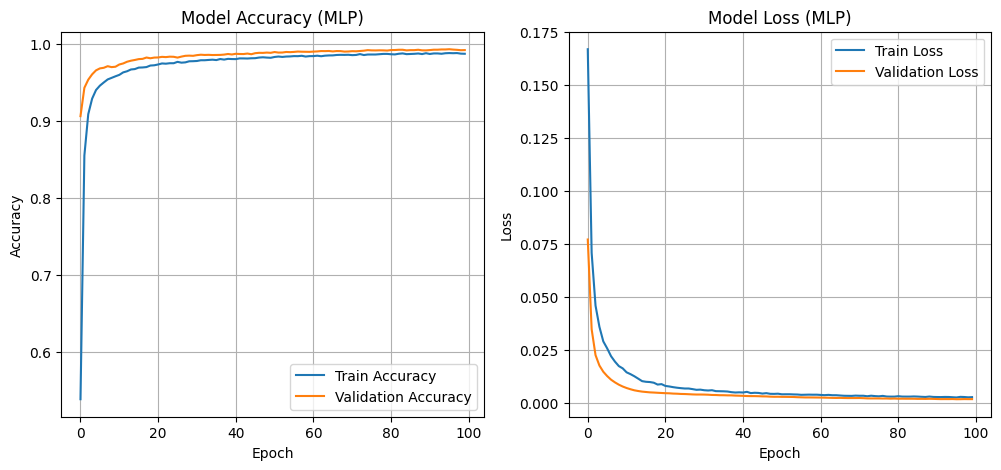

In [18]:
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


# ==============================================================================
# SAVE MODEL ARCHITECTURE DIAGRAM (Requires pydot and graphviz)
# ==============================================================================

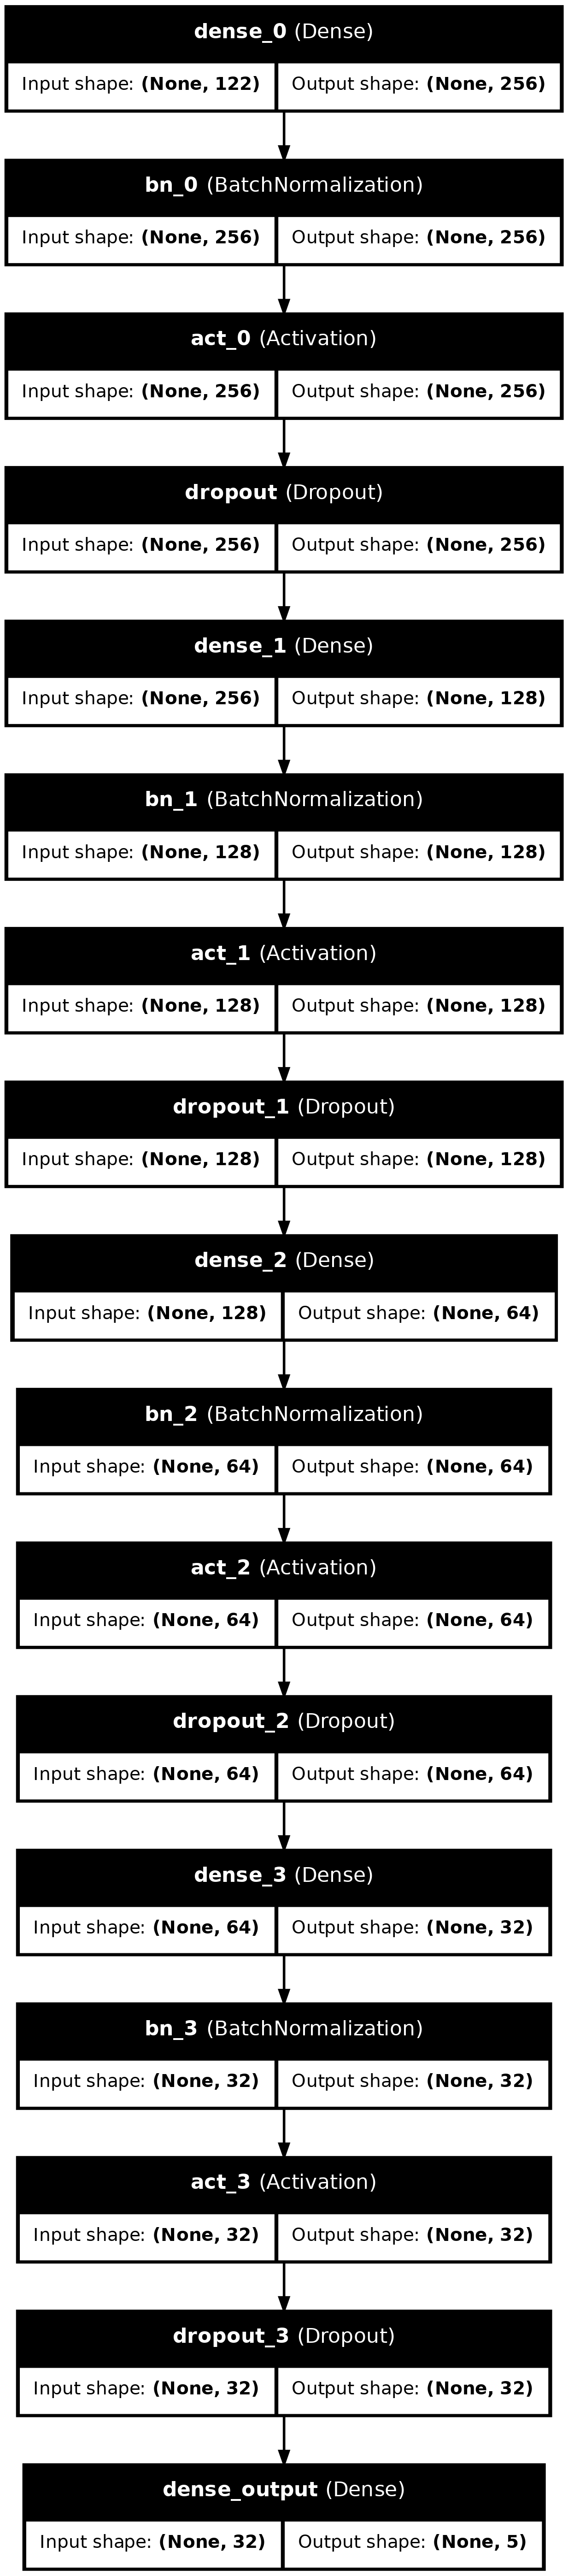

In [19]:
tf.keras.utils.plot_model(
    model, 
    to_file='mlp_architecture.png', 
    show_shapes=True, 
    show_layer_names=True
)